In [ ]:
!python -m pip install -qq kaggle

In [ ]:
%%bash
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download paultimothymooney/kermany2018
unzip -qq "/content/kermany2018.zip"
rm -rf  "/content/oct2017"                                                      # delete recursive data
mv "OCT2017 " "dataset"                                                            # rename main directory as data
mv "dataset/val" "dataset/valid"                                                      # rename val to valid
rm -rf "sample_data"

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100%|██████████| 10.8G/10.8G [01:47<00:00, 108MB/s]


In [ ]:
#@title Default title text
import os
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf                                                         # load tensorflow
import tensorflow_datasets as tfds                                              # tensorflow datasets

In [ ]:
for setType in ['dataset/train','dataset/test','dataset/valid']:
  classes=os.listdir(setType)                                                   # get all classes names
  print('Total classes:',len(classes))                                          # total classes
  print('Class names:',classes)                                                 # class names
  # clean class names
  classes_clean=[re.sub('[^A-Za-z0-9 ]',' ',class_) for class_ in classes]      # remove unwanted characters
  classes_clean=[re.sub('[ ]+','_',class_).casefold() for class_ in classes_clean]# replace one or multiple spaces by underscore '_'
  print('Cleaned Class names:',classes_clean)                                   # clean class names
  # rename class names with clean class names
  for old_name,new_name in zip(classes,classes_clean):                          # get old and new class names
    os.rename(os.path.join(setType,old_name),os.path.join(setType,new_name))# rename with new class names
  # get minimum class count ------------------------------------------------------
  class_counts:dict=dict()                                                      # get class samples for each class
  # get number of files in each class
  for class_ in os.listdir(setType):                                            # get class name folder
    class_counts[class_]=len(os.listdir(os.path.join(setType,class_)))          # count samples in given class
  print('Class counts:',class_counts)                                           # print class counts
assert os.listdir('dataset/train')==os.listdir('dataset/test')==os.listdir('dataset/valid'),'Different classes found in train and test'# check classes
training_classes=os.listdir('dataset/train')                                    # make list of training classes

Total classes: 4
Class names: ['CNV', 'DME', 'DRUSEN', 'NORMAL']
Cleaned Class names: ['cnv', 'dme', 'drusen', 'normal']
Class counts: {'drusen': 8616, 'cnv': 37205, 'dme': 11348, 'normal': 26315}
Total classes: 4
Class names: ['CNV', 'DME', 'DRUSEN', 'NORMAL']
Cleaned Class names: ['cnv', 'dme', 'drusen', 'normal']
Class counts: {'drusen': 242, 'cnv': 242, 'dme': 242, 'normal': 242}
Total classes: 4
Class names: ['CNV', 'DME', 'DRUSEN', 'NORMAL']
Cleaned Class names: ['cnv', 'dme', 'drusen', 'normal']
Class counts: {'drusen': 8, 'cnv': 8, 'dme': 8, 'normal': 8}


In [ ]:
# load dataset - train, test and valid
train=tf.keras.utils.image_dataset_from_directory('dataset/train',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                  batch_size=32,image_size=(256,256),shuffle=True,validation_split=0.0,
                                                  interpolation='bilinear',subset=None,)
test=tf.keras.utils.image_dataset_from_directory('dataset/test',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                 batch_size=32,image_size=(256,256),shuffle=False,validation_split=0.0,
                                                 interpolation='bilinear',subset=None,seed=8,)
valid=tf.keras.utils.image_dataset_from_directory('dataset/valid',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                  batch_size=128,image_size=(256,256),shuffle=True,validation_split=0.3,
                                                  interpolation='bilinear',subset='validation',seed=8,)
print('Total validation images:',test.cardinality()*32)
print('Total test images:',test.cardinality()*32)
training_classes:list=train.class_names
test_classes:list=test.class_names
valid_classes:list=valid.class_names
assert training_classes==test_classes,'class count in train and test set is not same'
print('Class names:',training_classes)

Found 83484 files belonging to 4 classes.
Found 968 files belonging to 4 classes.
Found 32 files belonging to 4 classes.
Using 9 files for validation.
Total validation images: tf.Tensor(992, shape=(), dtype=int64)
Total test images: tf.Tensor(992, shape=(), dtype=int64)
Class names: ['cnv', 'dme', 'drusen', 'normal']


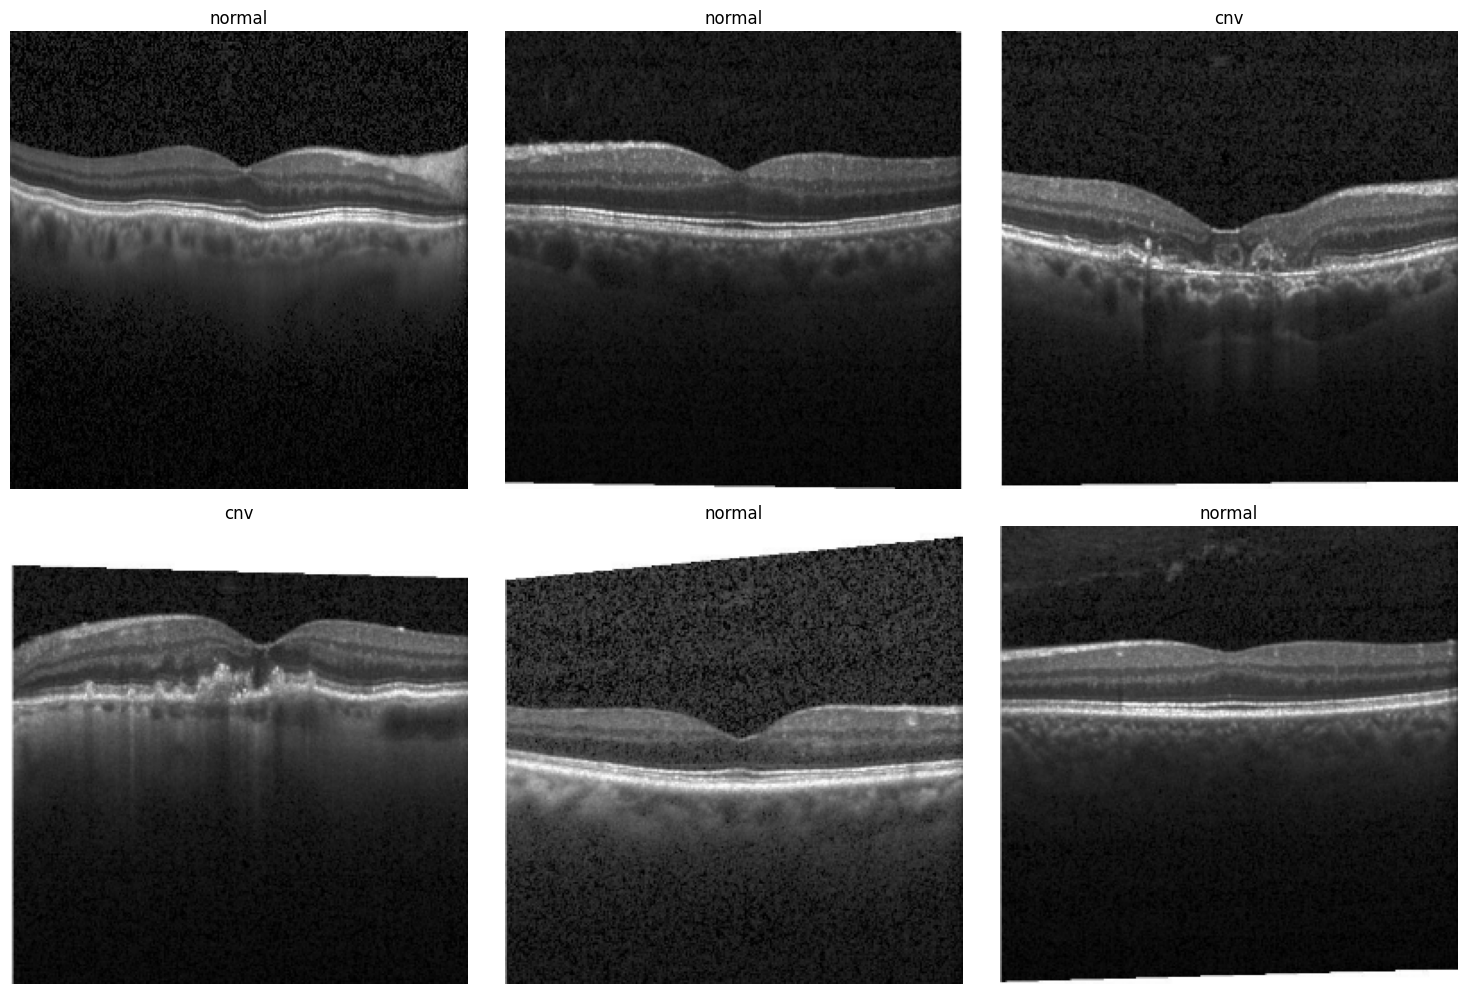

In [ ]:
# make plot data training data
for images,labels in train.take(1):break                                        # get a batch of data
images_to_plot:int=6                                                            # number of images to plot
plt.figure(figsize=(15,15))                                                     # figure size
for index in range(images_to_plot):                                             # loop over image index
  plt.subplot(3,3,index+1)                                                      # subplot rows = 3, columns = 3
  plt.imshow(images[index].numpy().astype('uint8'))                             # make plot image
  plt.axis('off')                                                               # make axis off
  plt.title(training_classes[labels[index].numpy()])                            # make add labels as class names
plt.tight_layout()                                                              # adjust layout space
plt.show()                                                                      # make plot show

In [ ]:
print('Maximum pixel values:',tf.reduce_max(images))                            # maximum pixel values in inputs
print('Minimum pixel values:',tf.reduce_min(images))                            # minimum pixel values in inputs
print('Object type of inputs (X):',type(images))                                # input types
print('Data type in inputs (X):',images.dtype)                                  # data type in inputs
print('Object type of outputs (y):',type(labels))                               # output types
print('Data type in outputs (X):',labels.dtype)                                 # data type in outputs

Maximum pixel values: tf.Tensor(255.0, shape=(), dtype=float32)
Minimum pixel values: tf.Tensor(0.0, shape=(), dtype=float32)
Object type of inputs (X): <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in inputs (X): <dtype: 'float32'>
Object type of outputs (y): <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in outputs (X): <dtype: 'int32'>


In [ ]:
# make apply data augmentation to data (add more randomness to data)
# source: https://www.tensorflow.org/tutorials/images/data_augmentation
random_flip=tf.keras.layers.RandomFlip('horizontal_and_vertical',name='random_flip')# random flip layer
random_zoom=tf.keras.layers.RandomZoom(height_factor=0.1,width_factor=0.1,name='random_zoom')# random zoom layer
random_rotate=tf.keras.layers.RandomRotation(0.3,name='random_rotate')          # random rotate layers
random_brightness=tf.keras.layers.RandomBrightness(0.3,value_range=(0.0,255.0),name='random_brightness')# random brightness layer
augmentations=[random_flip,random_zoom,random_rotate,random_brightness]         # make list of data augmentation
# make apply augmentation on training data
for augmentation in augmentations:
  train.map(lambda images,labels: (augmentation(images),labels))                # make apply augmentation

In [ ]:
# configure the dataset for performance
# source: https://www.tensorflow.org/tutorials/images/classification#configure_the_dataset_for_performance

# train=train.cache().shuffle(1024).prefetch(buffer_size=tf.data.AUTOTUNE)
# valid=valid.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# test=test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
model=tf.keras.Sequential(layers=None,name='eye-disease')
model.add(tf.keras.layers.Rescaling(1./255.,offset=0,name='rescaling_01',input_shape=(256,256,3)))
# first forward pass :: inputs : (256,256,3) -> outputs : (64,64,32)
model.add(tf.keras.layers.Conv2D(32,(7,7),strides=(2,2),padding='same',name='conv_32x7s2_02'))
model.add(tf.keras.layers.BatchNormalization(name='btz_norm_03'))
model.add(tf.keras.layers.ReLU(name='relu_04'))
model.add(tf.keras.layers.Conv2D(32,(3,3),strides=(2,2),padding='same',name='conv_32x3s2_05'))
model.add(tf.keras.layers.BatchNormalization(name='btz_norm_06'))
model.add(tf.keras.layers.ReLU(name='relu_07'))
# second forward pass :: inputs : (64,64,32) -> outputs : (32,32,64)
model.add(tf.keras.layers.Conv2D(64,(3,3),strides=(1,1),padding='same',name='conv_64x3s1_08'))
model.add(tf.keras.layers.BatchNormalization(name='btz_norm_09'))
model.add(tf.keras.layers.ReLU(name='relu_10'))
model.add(tf.keras.layers.Conv2D(64,(3,3),strides=(2,2),padding='same',name='conv_64x3s2_11'))
model.add(tf.keras.layers.BatchNormalization(name='btz_norm_12'))
model.add(tf.keras.layers.ReLU(name='relu_13'))
# third forward pass :: inputs : (32,32,64) -> outputs : (16,16,128)
model.add(tf.keras.layers.Conv2D(128,(3,3),strides=(1,1),padding='same',name='conv_128x3s1_12'))
model.add(tf.keras.layers.BatchNormalization(name='btz_norm_13'))
model.add(tf.keras.layers.ReLU(name='relu_14'))
model.add(tf.keras.layers.Conv2D(128,(3,3),strides=(2,2),padding='same',name='conv_128x3s2_15'))
model.add(tf.keras.layers.BatchNormalization(name='btz_norm_16'))
model.add(tf.keras.layers.ReLU(name='relu_17'))
# fourth forward pass :: inputs : (16,16,128) -> outputs : (8,8,256)
model.add(tf.keras.layers.Conv2D(256,(3,3),strides=(1,1),padding='same',name='conv_256x3s1_18'))
model.add(tf.keras.layers.BatchNormalization(name='btz_norm_19'))
model.add(tf.keras.layers.ReLU(name='relu_20'))
model.add(tf.keras.layers.Conv2D(256,(3,3),strides=(2,2),padding='same',name='conv_256x3s2_21'))
model.add(tf.keras.layers.BatchNormalization(name='btz_norm_22'))
model.add(tf.keras.layers.ReLU(name='relu_23'))
# add dense map to network
model.add(tf.keras.layers.Flatten(name='flatten_24'))
model.add(tf.keras.layers.Dense(1024,activation='relu',name='dense_1024_25'))
model.add(tf.keras.layers.Dropout(0.3,name='dropout_0__3_26'))
model.add(tf.keras.layers.Dense(1024,activation='relu',name='dense_1024_27'))
model.add(tf.keras.layers.Dropout(0.3,name='dropout_0__3_28'))
model.add(tf.keras.layers.Dense(len(training_classes),activation='softmax',name=f'dense_{len(training_classes)}_output_29'))


# make print model summary
model.summary(line_length=120,expand_nested=True,show_trainable=True)

Model: "eye-disease"
___________________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           Trainable  
 rescaling_01 (Rescaling)                             (None, 256, 256, 3)                             0                 Y          
                                                                                                                                   
 conv_32x7s2_02 (Conv2D)                              (None, 128, 128, 32)                            4736              Y          
                                                                                                                                   
 btz_norm_03 (BatchNormalization)                     (None, 128, 128, 32)                            128               Y          
                                                       

In [ ]:
# make compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [ ]:
# make early stopping
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',min_delta=0,patience=10,verbose=1,mode='auto',restore_best_weights=True)
1+2
# make train model
history=model.fit(train,batch_size=32,epochs=10_000,verbose=2,callbacks=[early_stop],validation_split=0,validation_data=test,
                  shuffle=True)

Epoch 1/10000
2609/2609 - 350s - loss: 0.6659 - sparse_categorical_accuracy: 0.7699 - val_loss: 0.5795 - val_sparse_categorical_accuracy: 0.7676 - 350s/epoch - 134ms/step
Epoch 2/10000
2609/2609 - 319s - loss: 0.3298 - sparse_categorical_accuracy: 0.8925 - val_loss: 0.2687 - val_sparse_categorical_accuracy: 0.8977 - 319s/epoch - 122ms/step
Epoch 3/10000
2609/2609 - 317s - loss: 0.2193 - sparse_categorical_accuracy: 0.9302 - val_loss: 0.0692 - val_sparse_categorical_accuracy: 0.9783 - 317s/epoch - 121ms/step
Epoch 4/10000
2609/2609 - 312s - loss: 0.1779 - sparse_categorical_accuracy: 0.9420 - val_loss: 1.1406 - val_sparse_categorical_accuracy: 0.7944 - 312s/epoch - 119ms/step
Epoch 5/10000
2609/2609 - 312s - loss: 0.1511 - sparse_categorical_accuracy: 0.9499 - val_loss: 0.0594 - val_sparse_categorical_accuracy: 0.9835 - 312s/epoch - 120ms/step
Epoch 6/10000
2609/2609 - 310s - loss: 0.1278 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.0617 - val_sparse_categorical_accuracy: 0.9783 

In [ ]:
# see model history (first five epoches)
pd.DataFrame(history.history).head()

In [ ]:
# see model history (last five epoches)
pd.DataFrame(history.history).tail()

In [ ]:
# make plot training accuracy and validation accuracy
pd.DataFrame(history.history)[['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot(marker='.')# make plot
plt.grid(),plt.title('Training Accuracy'),plt.xlabel('epochs'),plt.ylabel('accuracy')# add grid, title and axis labels
plt.show()                                                                      # make plot show

In [ ]:
# make plot training losses and validation losses
pd.DataFrame(history.history)[['loss','val_loss']].plot(marker='.')             # make plot
plt.grid(),plt.title('Training Losses'),plt.xlabel('epochs'),plt.ylabel('loss') # add grid, title and axis labels
plt.show()                                                                      # make plot show

In [ ]:
# evaluate model
results=model.evaluate(test,batch_size=None,verbose="auto",sample_weight=None,return_dict=True)
print('Testing results:',results)                                               # make print results

In [ ]:
!zip -r -qq "eye-disease.zip" "eye-disease"                     # make zip model
# make auto download model weights
from google.colab import files                                                  # load file class
files.download('eye-disease.zip')                                       # download model zip file